<a href="https://colab.research.google.com/github/devipriyaraju/NLP_Image_Captioning_Project/blob/main/Modified_InceptionV3_without_Pretrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import cv2
from google.colab import output
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time
import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations

import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as ET

In [28]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [29]:
from google.colab import files


In [30]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")


In [7]:
train = pd.read_pickle(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','train.pkl'))

test = pd.read_pickle(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','test.pkl'))

In [15]:
token = tf.keras.preprocessing.text.Tokenizer(filters = '',oov_token = '<unk>') 
token.fit_on_texts(train.Report_abs.values)
train_cap = token.texts_to_sequences(train.Report_abs) 
test_cap = token.texts_to_sequences(test.Report_abs) 
vocab_size = len(token.word_index)

for i in train_cap:
  report_len=np.array([len(i) for i in train_cap])
ind_start = token.word_index['<cls>']
end_start = token.word_index['<end>']

In [16]:
np.percentile(report_len,80)

30.0

Most of the captions have 30 as words in it and hence we will choose this value as maximum padding value.

In [17]:
import imgaug.augmenters as aug
from tensorflow.keras.preprocessing.text import Tokenizer
maximum_padding=30
augmentation=True
class Dataset():
  def __init__(self,dataframe,input_size,tokenizer = token,maximum_padding = 30,augmentation = augmentation): 
    """
    dataframe  = dataframe containing image_1,image_2 and impression
    """
    self.img1 = dataframe.Image1
    self.input_size = input_size 
    self.img2 = dataframe.Image2
    self.augmentation = augmentation
    self.Report_in = dataframe.Report_in
    self.tokenizer = tokenizer
    self.Report_out = dataframe.Report_out 
    self.maximum_padding = maximum_padding
    self.aug1 = aug.Fliplr(1)
    self.aug2 = aug.Sharpen(alpha=(1.0), lightness=(0.8))
    self.aug3 = aug.Flipud(1) 

  def __getitem__(self,i):
    img1 = cv2.imread(self.img1[i],cv2.IMREAD_UNCHANGED)
    img2 = cv2.imread(self.img2[i],cv2.IMREAD_UNCHANGED)
    img1=img1/255
    img2=img2/255
    img1 = cv2.resize(img1,self.input_size,interpolation = cv2.INTER_NEAREST)
    img2 = cv2.resize(img2,self.input_size,interpolation = cv2.INTER_NEAREST)

    Report_in = self.tokenizer.texts_to_sequences(self.Report_in[i:i+1]) 
    Report_in = tf.keras.utils.pad_sequences(Report_in,maxlen = self.maximum_padding,padding = 'post') 
    Report_in = tf.squeeze(Report_in,axis=0)
    Report_out = self.tokenizer.texts_to_sequences(self.Report_out[i:i+1]) 
    Report_out = tf.keras.utils.pad_sequences(Report_out,maxlen = self.maximum_padding,padding = 'post')
    Report_out = tf.squeeze(Report_out,axis=0)
    if self.augmentation:
          a = np.random.uniform()
          if a<0.2:
              img1 = self.aug1.augment_image(img1)
              img2 = self.aug1.augment_image(img2)
          elif a<0.7:
              img1 = self.aug3.augment_image(img1)
              img2 = self.aug3.augment_image(img2)
          else: #applying no augmentation
              img1 = self.aug2.augment_image(img1)
              img2 = self.aug2.augment_image(img2)

    
    return img1,img2,Report_in,Report_out
 
  def __len__(self):
    return len(self.img1)

class Dataloader(tf.keras.utils.Sequence): 
    def __init__(self,dataframe,batch_size=1):
        self.dataframe = dataframe
        self.shuffle = True
        self.batch_size = batch_size
        l=len(self.dataframe)
        self.length = np.arange(l)

    def __getitem__(self, i):
      
        ini = i * self.batch_size*i
        end = self.batch_size + ini
        length = [self.length[j] for j in range(ini,end)] 
        dataset = [self.dataframe[j] for j in length]
        batches = [np.stack(samples, axis=0) for samples in zip(*dataset)]


        return tuple([[batches[0],batches[1],batches[2]],batches[3]])
    
    def __len__(self):
        return len(self.length) // self.batch_size
    
    def on_batch_end(self):
        if self.shuffle==True:
            np.random.shuffle(self.length)
     

In [18]:
batch_size=100
input_size = (224,224)
ebd_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.1
train_dataset = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataset,batch_size = 100)


test_dataset = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataset,batch_size = 100)
     

In [ ]:
'''
#train_img_features_samp=np.zeros((7625,98,1024))
#test_img_features_samp=np.zeros((848,98,1024))

for i in (range(train.shape[0])):

    image_1=train.iloc[i]["Image1"]
    image_2=train.iloc[i]["Image2"]
    #NLMCXR_png1/CXR1000_IM-0003-1001.png
    train_img_features_samp[i]=(pre_process('NLMCXR_png1/'+image_1,'NLMCXR_png1/'+image_2,train.iloc[i]["Report_in"],train.iloc[i]["Report_out"]))
    
for i in (range(test.shape[0])):

    image_1=test.iloc[i]["Image1"]
    image_2=test.iloc[i]["Image2"]
    #NLMCXR_png1/CXR1000_IM-0003-1001.png
    print(i)
    test_img_features_samp[i]=(pre_process('NLMCXR_png1/'+image_1,'NLMCXR_png1/'+image_2,test.iloc[i]["Report_in"],test.iloc[i]["Report_out"]))
    '''

'\n#train_img_features_samp=np.zeros((7625,98,1024))\n#test_img_features_samp=np.zeros((848,98,1024))\n\nfor i in (range(train.shape[0])):\n\n    image_1=train.iloc[i]["Image1"]\n    image_2=train.iloc[i]["Image2"]\n    #NLMCXR_png1/CXR1000_IM-0003-1001.png\n    train_img_features_samp[i]=(pre_process(\'NLMCXR_png1/\'+image_1,\'NLMCXR_png1/\'+image_2,train.iloc[i]["Report_in"],train.iloc[i]["Report_out"]))\n    \nfor i in (range(test.shape[0])):\n\n    image_1=test.iloc[i]["Image1"]\n    image_2=test.iloc[i]["Image2"]\n    #NLMCXR_png1/CXR1000_IM-0003-1001.png\n    print(i)\n    test_img_features_samp[i]=(pre_process(\'NLMCXR_png1/\'+image_1,\'NLMCXR_png1/\'+image_2,test.iloc[i]["Report_in"],test.iloc[i]["Report_out"]))\n    '

In [ ]:
'''np.save("train_features_samp",train_img_features_samp)
np.save("test_features_samp",test_img_features_samp)'''

In [ ]:
'''train_img_features=np.load("train_features_samp.npy")
test_img_features=np.load("test_features_samp.npy") '''

In [19]:
glv = {}
with open('glove.6B.300d.txt',encoding='utf-8') as file: 
  for i in file:
    word = i.split()
    glv[word[0]] = np.asarray(word[1:], dtype='float32')

In [20]:

emb_dim = 300
emb_mat = np.zeros((vocab_size+1, emb_dim)) 

for word, i in token.word_index.items():
  vec = glv.get(word)
  if vec is not None:
      emb_mat[i] = vec[:emb_dim]
     

**CHexNet Model:**

In [33]:
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf


img_inp = Input(shape=(224,224,3))
base_model = keras.models.load_model("Modified_incpetionv3")

layer0 = base_model.layers[-2].output


final_model = tf.keras.Model(inputs= base_model.input, outputs= layer0)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

**Image Encoder:**

In [34]:
den_dim=512
emb_dim =300
lstm_units= 512
dropout_rate = 0.1
attention_units=512

In [35]:
class Img_encoder(tf.keras.layers.Layer):

  def __init__(self,name = "Img_encoder"):
    super().__init__()
    self.chexnet = final_model
    self.chexnet.trainable = False
    self.avgpool = tf.keras.layers.AveragePooling2D()
  
  def call(self,data):
    l1 = self.avgpool(self.chexnet(data)) 
    out = tf.reshape(l1,shape = (-1,l1.shape[1]*l1.shape[2],l1.shape[3]))
    return out 
def Encoder(img1,img2,dense_dim = den_dim,dropout_rate = dropout_rate):

  im_encoder = Img_encoder()
  img1_feat = im_encoder(img1) 
  func1 = tf.keras.layers.Dense(dense_dim,name = 'enc_func1',activation = 'relu') 
  img1_feat = func1(img1_feat)
  img2_feat = im_encoder(img2) 
  img2_feat = func1(img2_feat)
  concat = tf.keras.layers.Concatenate(axis=1)([img1_feat,img2_feat]) 
  bn = tf.keras.layers.BatchNormalization(name = "Img_encoder_bn")(concat) 
  dropout = Dropout(dropout_rate,name = "Img_encoder_do")(bn)
  return dropout
     

Local Attention:

In [36]:
class Attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = den_dim):
    super().__init__()
    self.weight_matrix1 = tf.keras.layers.Dense(units = dense_dim)
    self.weight_matrix2 = tf.keras.layers.Dense(units = dense_dim)
    self.V = tf.keras.layers.Dense(units = 1)

  def call(self,enc_out,hidden_decode):
    hidden_decode = tf.expand_dims(hidden_decode,axis=1)
    tanh_inp = self.weight_matrix1(enc_out) + self.weight_matrix2(hidden_decode)
    tanh_out =  tf.nn.tanh(tanh_inp)
    attention_weights = tf.nn.softmax(self.V(tanh_out),axis=1)
    out = attention_weights*enc_out
    convt_vec = tf.reduce_sum(out,axis=1)


    return convt_vec,attention_weights

In [37]:
max_padding=30
class Decode1(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = 300, max_pad = max_padding, dense_dim = den_dim ,name = "decoder1"):
    super().__init__()
    self.dense_dim = dense_dim
    self.ebd = tf.keras.layers.Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length=max_pad,weights = [emb_mat],mask_zero=True,name = 'decoder1_emb')
    self.LSTM = tf.keras.layers.GRU(units=self.dense_dim,return_state=True,name = 'decoder1_lstm')
    self.attention = Attention(dense_dim  = dense_dim)
    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'decoder1_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.concat = tf.keras.layers.Concatenate(axis=-1)
    self.add =tf.keras.layers.Add()

  @tf.function
  def call(self,dec_inp, encoder_output, hidden_dec):
 
    emb_out = self.ebd(dec_inp)

    con_vec,attention_weights = self.attention(encoder_output,hidden_dec) 
    con_vec_time = tf.expand_dims(con_vec,axis=1)
    concat_input = self.concat([con_vec_time,emb_out])
    
    out,hidden_dec = self.LSTM(concat_input,initial_state = hidden_dec)
    out = self.final(out)
    return out,hidden_dec,attention_weights
     

In [38]:

class Decode2(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_padding, embedding_dim = 300,dense_dim = 512,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.decode1 = Decode1(vocab_size = vocab_size, embedding_dim = ebd_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.mat_out = tf.TensorArray(tf.float32,size=max_pad)
    self.dense_dim =dense_dim
    self.batch_size = batch_size
    self.max_pad = max_pad
    
  @tf.function
  def call(self,encoder_output,caption):
    hidden_decode1, _ = tf.zeros_like(encoder_output[:,0]), tf.zeros_like(encoder_output[:,0])
    print("decoder_h_shape",hidden_decode1.shape)
    mat_out = tf.TensorArray(tf.float32,size=30)
    for ts in range(self.max_pad):
      output,hidden_decode1,attention_weights = self.decode1(caption[:,ts:ts+1], encoder_output, hidden_decode1)
      mat_out = mat_out.write(ts,output)
    self.mat_out = tf.transpose(mat_out.stack(),[1,0,2])
    return self.mat_out
     

In [39]:
#model creation
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) 
image2 = Input(shape = (input_size + (3,))) 
caption = Input(shape = (30,))

encoder_output = Encoder(image1,image2) 
output = Decode2()(encoder_output,caption)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

decoder_h_shape (None, 512)


In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_encoder (Img_encoder)      (None, 4, 2048)      18697568    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

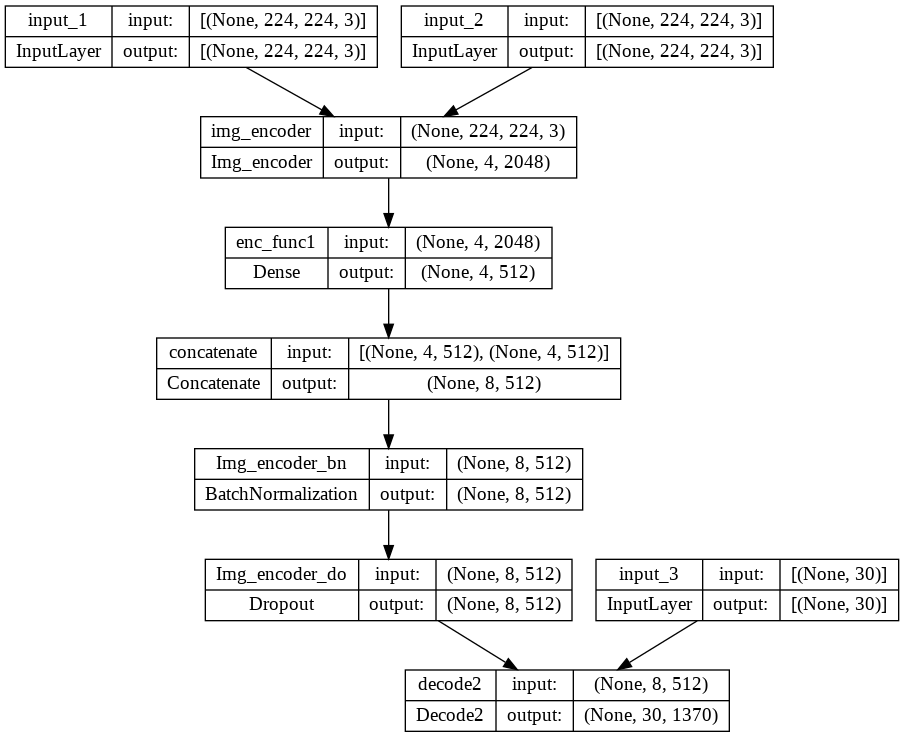

In [41]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )
     

In [42]:
loss_f = tf.keras.losses.SparseCategoricalCrossentropy() 
def loss_function(y_true,y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss1 = loss_f(y_true, y_pred)
  loss2 = loss_f(y_true, y_pred)*(tf.cast(mask, dtype=loss1.dtype))
  return tf.reduce_mean(loss2)

optimi = tf.keras.optimizers.Adam(learning_rate = 10**-2)   
model.compile(optimizer=optimi,loss=loss_function,metrics= ['accuracy'])
     


In [43]:
tf.keras.backend.clear_session()
model_save = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','inceptionv3_attention_2.h5')

dir_file = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/','inceptionv3_attention_logs')
my_callbacks = [
    tf.keras.callbacks.TensorBoard(histogram_freq=1,log_dir=dir_file),tf.keras.callbacks.EarlyStopping(patience = 7,verbose = 1,mode="min"),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,save_best_only = True,save_weights_only = True,verbose = 1,save_freq="epoch"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose = 1,patience=4, min_lr=10**-9, mode="min" )
                                   
] 
     

In [70]:
history=model.fit(train_dataloader,validation_data = test_dataloader,epochs = 10,callbacks = my_callbacks)

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 2.8700 - accuracy: 0.6286 
Epoch 1: val_loss improved from inf to 1.98741, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================] - 2448s 56s/step - loss: 2.8700 - accuracy: 0.6286 - val_loss: 1.9874 - val_accuracy: 0.7949 - lr: 0.0100
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 2.0507 - accuracy: 0.7677
Epoch 2: val_loss improved from 1.98741 to 1.81786, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================] - 98s 2s/step - loss: 2.0507 - accuracy: 0.7677 - val_loss: 1.8179 - val_accuracy: 0.8002 - lr: 0.0100
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 1.6201 - accuracy: 0.8595
Epoch 3: val_loss improved from 1.81786 to 1.69507, saving model to /content/gdrive/MyDrive/Colab Notebooks/densenet_attention_2.h5
44/44 [==============================]

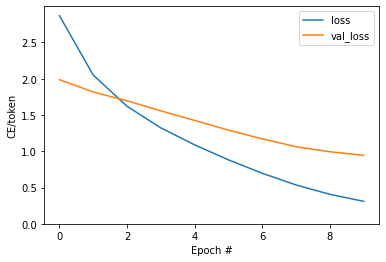

In [71]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [72]:
model.save_weights('modified_inceptionV3_attention_2.h5')
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights('modified_inceptionV3_attention_2.h5')

Beam Search:

In [73]:
def Beam_Search(img1,img2,n=3,max_pad = 30,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  n = n
  cls_token = tokenizer.texts_to_sequences([''])[0] #[3]
  
  img1 = cv2.imread(img1,cv2.IMREAD_UNCHANGED)/255 
  img2 = cv2.imread(img2,cv2.IMREAD_UNCHANGED)/255
  img1 = tf.expand_dims(cv2.resize(img1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  img2 = tf.expand_dims(cv2.resize(img2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  img1 = model.get_layer('image_encoder')(img1)
  img2 = model.get_layer('image_encoder')(img2)
  img1 = model.get_layer('enc_func1')(img1)
  img2 = model.get_layer('enc_func1')(img2)
  concat_layer = model.get_layer('concatenate')([img1,img2])
  enc_out = model.get_layer('Img_encoder_bn')(concat_layer)  
  enc_out = model.get_layer('Img_encoder_do')(enc_out)

  hidden_states = tf.zeros_like(enc_out[:,0]) 
  score_sequence = [[cls_token,0,hidden_states]]
  final_score = []
  for i in range(max_pad): 
    top_seq = [] 
    new_score_sequence = [] 
    for p in score_sequence: 
      input_ = p[0][-1] 
      hidden_states = p[2]
      caption = np.array([[input_]]) 
      output,hidden_states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_out,hidden_states) 
      n_words = tf.argsort(output[0],direction = 'DESCENDING')[:n] 

      seq,score,_ = p
      v=n_words.numpy()
      for u in v:
        candidates = [seq+[u],score-np.log(output[0][u].numpy()),hidden_states] 
        top_seq.append(candidates)
      score_sequence = sorted(top_seq,key = lambda l:l[1])[:n]
      count = 0
      end_token = tokenizer.word_index['']
      for seq,score,state in score_sequence:
        if seq[-1] == end_token: 
          final_score.append([seq,score])
          count+=1
        else:
          new_score_sequence.append([seq,score,state])
      n-=count 
      score_sequence = new_score_sequence
      if score_sequence==[]:
        break;
      else:
        continue;
  score_sequence = final_score[-1]
  sent = score_sequence[0][1:-1] 
  score = score_sequence[1]
  to = tokenizer.sequences_to_texts([sent])
  return to[0]

In [74]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  
  image1 = model.get_layer('image_encoder')(image1)
  image1 = model.get_layer('enc_func1')(image1)
  image2 = model.get_layer('image_encoder')(image2)
  image2 = model.get_layer('enc_func1')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  concat = model.get_layer('Img_encoder_bn')(concat)
  concat = model.get_layer('Img_encoder_do')(concat)
  return concat

In [75]:
def Beam_Search(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  enc_op = encoder_op(image1,image2)
  states = tf.zeros_like(enc_op[:,0])
  seq_score = [[cls_token,0,states]]
  finished_seq_score = []
  for i in range(max_pad): 
    all_candidates = [] 
    new_seq_score = []
    for s in seq_score: 
      text_input = s[0][-1] 
      states = s[2]
      caption = np.array([[text_input]])
      output,states,attention_weights =  model.get_layer('decoder').onestepdecoder(caption,enc_op,states) 
      top_words = tf.argsort(output[0],direction = 'DESCENDING')[:k] 

      seq,score,_ = s
      for t in top_words.numpy():
        candidates = [seq+[t],score-np.log(output[0][t].numpy()),states] 
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] 
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        if seq[-1] == end_token:
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count 
      seq_score = new_seq_score

      if seq_score==[]:
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] 
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]

In [ ]:
image1,image2 = test1.image_1.iloc[1],test1.image_2.iloc[1]
print(Beam_Search(image1,image2))   #Takes more than 1hour 30 mins

Greedy Search:

In [77]:
def Greedy_Search(img1,img2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  img1 = cv2.imread(img1,cv2.IMREAD_UNCHANGED)/255 
  img2 = cv2.imread(img2,cv2.IMREAD_UNCHANGED)/255
  img1 = tf.expand_dims(cv2.resize(img1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) 
  img2 = tf.expand_dims(cv2.resize(img2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  img1 = model.get_layer('image_encoder')(img1)
  img1 = model.get_layer('enc_func1')(img1)
  img2 = model.get_layer('image_encoder')(img2)
  img2 = model.get_layer('enc_func1')(img2)

  concat = model.get_layer('concatenate')([img1,img2])
  concat = model.get_layer('Img_encoder_bn')(concat)
  concat = model.get_layer('Img_encoder_do')(concat) 


  hidden_decode,_ = tf.zeros_like(concat[:,0]),tf.zeros_like(concat[:,0])
  probabilities = []
  for i in range(max_pad):
    if i==0: 
      seq = np.array(tokenizer.texts_to_sequences(['<cls>'])) 
    output,hidden_decode,attention_weights = model.get_layer('decoder').onestepdecoder(seq,concat,hidden_decode)
    max_prob = tf.argmax(output,axis=-1)
    seq = np.array([max_prob])
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      probabilities.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([probabilities])[0] 


In [78]:
i=0
img1,img2 = test1.image_1.iloc[i],test1.image_2.iloc[i]
print(Greedy_Search(img1,img2,model1))

no acute cardiopulmonary process . if patient is concern for soft tissue bone or bony abnormality of the thorax


**Calculating BLEU Score:**

In [79]:
from nltk.translate.bleu_score import sentence_bleu #bleu score
def calculating_BLEU(ref,pred):
  """
  Given a ref and pred string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  ref = [ref.split()]
  pred = pred.split()
  score1 = sentence_bleu(ref,pred,weights = (1,0,0,0))
  score2 = sentence_bleu(ref,pred,weights = (0.5,0.5,0,0))
  score3 = sentence_bleu(ref,pred,weights = (0.33,0.33,0.33,0))
  score4 = sentence_bleu(ref,pred,weights = (0.25,0.25,0.25,0.25))

  return score1,score2,score3,score4
     

In [80]:
def avg_score(test1,predict,model=model1):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  score1,score2,score3,score4 = [],[],[],[]
  for index,data in test1.iterrows():
    li1=[]
    
    predict_val = predict(data['image_1'],data['image_2'],model = model)
    true = data.impression
    li1 = calculating_BLEU(true,predict_val)
    score1.append(li1[0])
    score2.append(li1[1])
    score3.append(li1[2])
    score4.append(li1[3])
  return np.array(score1).mean(),np.array(score2).mean(),np.array(score3).mean(),np.array(score4).mean()

In [81]:
avg_scores = avg_score(test1,Greedy_Search)

In [82]:
ans = pd.DataFrame([list(avg_scores)],columns = ["BLEU_Score1","BLEU_Score2","BLEU_Score3","BLEU_Score4"],index = ["Greedy Search"])
ans

,BLEU_Score1,BLEU_Score2,BLEU_Score3,BLEU_Score4
Greedy Search,0.161686,0.078416,0.041566,0.006891


In [83]:
test1['BLEU Score'] = np.zeros(test1.shape[0]) 
test1['Predictions'] = np.zeros(test1.shape[0])

for index,rows in test1.iterrows():
  pred_list = Greedy_Search(rows.image_1,rows.image_2,model1)
  test1.loc[index,'Predictions'] = pred_list
  ref = [rows['impression'].split()]
  test1.loc[index,'BLEU Score'] = sentence_bleu(ref,pred_list.split(),weights = (0.33,0.33,0.33,0))

In [84]:
test1['Predictions'].value_counts()/test1.shape[0]

no acute cardiopulmonary process . if there is concern for soft tissue bone or bony abnormality of the thorax                                               0.541741
no acute cardiopulmonary process . if patient is concern for soft tissue bone or bony abnormality of the thorax                                             0.174067
no acute cardiopulmonary abnormalities . low lung volumes causing bibasilar atelectasis and bronchovascular crowding                                        0.120782
no acute cardiopulmonary process . if patient s symptoms persist recommend repeat study chest in one                                                        0.078153
no acute cardiopulmonary abnormalities . no acute bony abnormalities . if there is continued concern for occult fracture consider dedicated rib series .    0.046181
no acute cardiopulmonary abnormalities . specifically no pneumothorax . fractures of the posterior left h h and h ribs age indeterminate .                  0.012433
no acute c

We can see that for a good number of data, the model does a good job. But we can also see that most of the captions indicate "no acute cardiopulmonary abnormality .". This might hav eled to the imbalance of the datatset. Inspite of handling the imbalanced data with downsampling and upsampling, it didnt help much with the results.

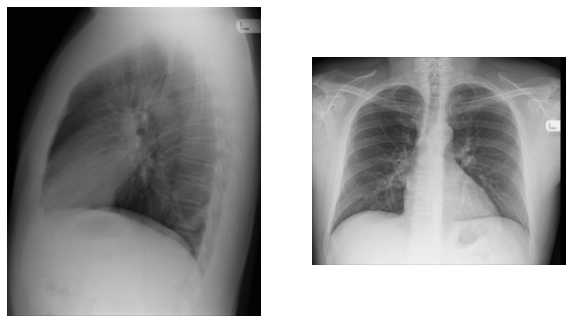


True caption: 'no acute cardiopulmonary disease'
Predicted through Greedy Method: 'no acute cardiopulmonary abnormalities . low lung volumes causing bibasilar atelectasis and bronchovascular crowding'




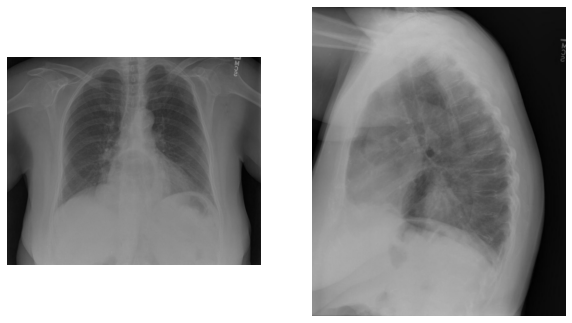


True caption: 'no acute cardiopulmonary process . large hiatal hernia .'
Predicted through Greedy Method: 'no acute cardiopulmonary abnormalities . low lung volumes causing bibasilar atelectasis and bronchovascular crowding'




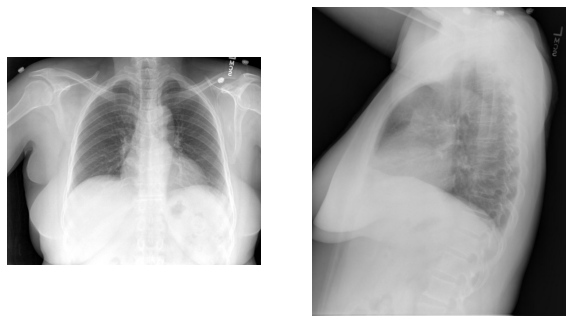


True caption: 'heart size is normal and lungs are clear .'
Predicted through Greedy Method: 'no acute cardiopulmonary process . if patient is concern for soft tissue bone or bony abnormality of the thorax'




In [90]:
sample = test1[(test1['BLEU Score']<0.90)].sample(3,replace=True).index
for _,p in enumerate(sample):
  image1,image2 = test1['image_1'][p],test1['image_2'][p]
  true = test1['impression'][p]
  
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  Greedy_Predicted = Greedy_Search(image1,image2,model1)
  plt.figure(figsize = (10,20))
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true))
  print("Predicted through Greedy Method: '%s'"%(Greedy_Predicted))
  print("\n")